In [1]:
pip install umap-learn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=d27d051f65443d87929f23af8bc75b8f086f1fdde70df08363003893c22b64ee
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=ed33035e67236fc86997125e69e9e21db8df0eb142f559605b74d17a585b44ef
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
!nvidia-smi

Tue May 30 18:06:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd # Datafram
import numpy as np # Array and math
import matplotlib.pylab as plt # Plot
import umap  # pip install umap-learn 
import io # Path
import re # Replace string to clean data
import nltk # Using stopwords
nltk.download('stopwords')
nltk.download('punkt')
import time # Measure time
import gc
import torch 
import torch.nn as nn # Using and create module, class
import torch.optim as optim # Optimization
from nltk.tokenize import word_tokenize # Tokenize text
from nltk.stem import PorterStemmer # Filler out the short word
from nltk.corpus import stopwords # Stopwords
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence # Padding 
from torch.utils.data import DataLoader, TensorDataset # Divide into batch, create dataset for training
from sklearn.datasets import fetch_20newsgroups # Dataset
from sklearn.model_selection import train_test_split # Split train - test for lstm model
from sklearn.preprocessing import StandardScaler # Scaler
from sklearn.model_selection import cross_val_score # Choose hyperparameters
from tqdm.notebook import tqdm # Information when train, test
from sklearn.neighbors import KNeighborsClassifier # KNN for classification
from sklearn.metrics import accuracy_score # Check algorithm is good or not
from sklearn.feature_extraction.text import TfidfVectorizer # Embed text 
from sklearn.feature_extraction.text import CountVectorizer # Embed text
from umap import validation # Trustworthiness_umap
from warnings import filterwarnings # Delete warning

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Embedding text using bag of word, tf-idf, pre-train model and visualize using umap
- Load data set which is fetch_20newsgroups in sklearn.
- Text cleaning by eliminating stopwords and fill out short words.
- Drop all columns which is not meaningful.
- Embed data using bag of word
- Embed data using tf-idf
- Tokenize text and using pre-train model of glove to embed.
- Apply umap.


In [4]:
def load_data():
    # Load dataset 20newsgroups from sklearn
    dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
    
    # Convert data to dataframe
    df = pd.DataFrame()
    df['text'] = dataset.data
    df['source'] = dataset.target
    return df, dataset 


def eleminate_not_word(text):
    cleaner = re.sub(r"[^a-zA-Z ]+", ' ', text.lower()) # Lowercase and strip everything except words
    return cleaner


def tokenize(text):
    cleaner = word_tokenize(text) # Tokenize text to words
    return cleaner


def eleminate_stop_word_and_padding(text):
    stopWords = set(stopwords.words('english')) # Download stopwords English from nltk
    ps = PorterStemmer() # Initial filler out short words
    clean = []
    for w in text:
        # filter out stopwords
        if w not in stopWords:
            # filter out short words
            if len(w) > 2:
                # Stem 
                clean.append(ps.stem(w))
    return clean


def text_cleaner(text):
    only_word = eleminate_not_word(text)
    token_word = tokenize(only_word)
    clean_text = eleminate_stop_word_and_padding(token_word)
    return clean_text


def get_final_data(text_column, clean_text_column, target_column):
    df, dataset = load_data() # Load data
    df[clean_text_column] = df[text_column].apply(lambda x: text_cleaner(x)) # data cleaning
    df['len_sentence'] = df[clean_text_column].apply(lambda x: len(x)) # Get len of text
    df = df.drop(df[df['len_sentence'] == 0].index) # Drop text don't have any word
    return df, dataset


def load_word_embeddings(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') # Read file
    vocab, matrix = [], []
    for line in fin: # Each line
        tokens = line.rstrip().split(' ') # Tokenize
        vocab.append(tokens[0]) # Add vocab
        matrix.append(list(map(float, tokens[1:]))) # Add embedding
    return vocab, matrix


def get_embedding_glove():
    !wget http://nlp.stanford.edu/data/glove.6B.zip # Download glove
    !unzip glove.6B.zip # Unzip or extract file
    vocab, matrix = load_word_embeddings("glove.6B.100d.txt") # Get embedding matrix with glove have 100 dim
    embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode='constant', constant_values =0.0)  # Padding to equal length
    return vocab, embedding_matrix


def text_to_index(tokenized_texts, vocab, unknown_word):
    X = []
    word_to_index = {word: index+2 for index, word in enumerate(vocab)}

    for text in tokenized_texts:
        cur_text_indices = []
        for word in text:
            if word in word_to_index:
                cur_text_indices.append(word_to_index[word])    
            else:
                cur_text_indices.append(unknown_word)       
        X.append(cur_text_indices)
    return X


def get_index_embedding(tokenized_texts, target_column, vocab, matrix):
    X = text_to_index(tokenized_texts, vocab, 1) # Convert our text to index using above embedding matrix
    y = target_column.values # Get target
    return X, y


def get_embedding_matrix(X, embedding_matrix):
    text_embedding = [] 
    for text_index in X: # Each text
        embeddings = []
        for word_index in text_index: # Each word
            embeddings.append(embedding_matrix[word_index]) # Get embedding vector from pre-train model
        text_embedding.append(np.mean(embeddings, axis=0)) # Using mean for all vector of text
    return text_embedding


def umap_reduce_dim(X_train, y_train, X_test):
    manifold = umap.UMAP(
              n_neighbors=15,
              min_dist=0.1,
              n_components=2,
              metric='cosine',
              random_state=42
              )
    X_reduced_train = manifold.fit_transform(X_train, y_train)
    X_reduced_test = manifold.transform(X_test)
    return X_reduced_train, X_reduced_test


def plot_scatter(X_train, y_train, X_test, y_test, algorithm):
    print("Algorithm: " + algorithm)
    print("Data train after embedding")
    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=0.5, cmap='Spectral')
    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=0.5, cmap='Spectral')
    print("Data test after embedding")
    plt.show()


def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 62)
    return X_train, X_test, y_train, y_test

In [5]:
# Initial
text_column = 'text'
clean_text_column = 'clean_text_stem'
target_column = 'source'
n_class = 20  

In [6]:
# Load data
df, dataset = get_final_data(text_column, clean_text_column, target_column) # Get data with dataframe type
X_train, X_test, y_train, y_test = split_train_test(df[text_column], df[target_column]) # Split train test 

In [7]:
X_train_bow = X_train.apply(lambda x: eleminate_not_word(x)) # Data cleaning
X_test_bow = X_test.apply(lambda x: eleminate_not_word(x)) # Data cleaning

In [8]:
# Bag of word
vectorizer_BOW = CountVectorizer(max_features=1000, stop_words='english', lowercase=False)
X_train_BOW = vectorizer_BOW.fit_transform(X_train_bow)
X_test_BOW = vectorizer_BOW.transform(X_test_bow)

X_reduced_train_BOW, X_reduced_test_BOW = umap_reduce_dim(X_train_BOW.toarray(), y_train, X_test_BOW.toarray())

In [9]:
# Tfidf
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_bow)
X_test_tfidf = vectorizer_tfidf.transform(X_test_bow)


X_reduced_train_tfidf, X_reduced_test_tfidf = umap_reduce_dim(X_train_BOW.toarray(), y_train, X_test_BOW.toarray())

In [10]:
# Glove
X_train_glove = X_train.apply(lambda x: text_cleaner(x)) # data cleaning
X_test_glove = X_test.apply(lambda x: text_cleaner(x)) # data cleaning
tokenized_texts_train = X_train_glove.to_list()
tokenized_texts_test = X_test_glove.to_list()
vocab, embedding_matrix = get_embedding_glove() # Get embedding matrix from glove
X_index_train, y_label_train= get_index_embedding(tokenized_texts_train, y_train, vocab, embedding_matrix)
X_index_test, y_label_test = get_index_embedding(tokenized_texts_test,  y_test, vocab, embedding_matrix)
text_embedding_train = get_embedding_matrix(X_index_train, embedding_matrix)
text_embedding_test = get_embedding_matrix(X_index_test, embedding_matrix)

--2023-05-30 18:10:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-30 18:10:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-30 18:10:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Another way to embed text: Using LSTM to train after embedding from pre-train model.
- Split train - test data.
- Convert these data to tensor.
- Divide into many batches.
- Build LSTM model including embedding layer - using pre-train model, LSTM layer which have output we use to embedding martrix, FC layer.
- Inititalize object which is cross entropy and optimizer which is Adam.
- Get embedding matrix and apply umap.

In [11]:
# Split train - test for lstm task, 
X_train_lstm, X_valid_lstm, y_train_lstm, y_valid_lstm =  split_train_test(X_index_train, y_label_train)

In [12]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs = [torch.tensor(input, dtype=torch.long) for input in inputs]
    seq_len = [len(input) for input in inputs]
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    seq_len = torch.tensor(seq_len)
    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    return inputs, seq_len, labels


def create_attention_mask(sequence_lengths, max_length):
    batch_size = len(sequence_lengths)
    attention_masks = torch.zeros(batch_size, max_length, dtype=torch.float32)

    for i, seq_len in enumerate(sequence_lengths):
        attention_masks[i, :seq_len] = 1.0

    return attention_masks


def mean_pooling(token_embeddings, attention_mask):
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


class LSTMModel(nn.Module):
    def __init__(self, embedding_matrix, n_class):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=128, bidirectional=True)
        self.fc = nn.Linear(256, n_class)

    def forward(self, x, attn_mask):
        x = self.embedding(x)
        output, (hidden, _) = self.lstm(x)
        output = mean_pooling(output, attn_mask)
        # x = self.fc(hidden.squeeze(0))
        x = self.fc(output).squeeze()
        return x, output

    
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.y)

    
train_dataset = NewsDataset(X_train_lstm, y_train_lstm)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_dataset = NewsDataset(X_valid_lstm, y_valid_lstm)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)


device = 'cuda:0'
# Initialize the model, loss, and optimizer
model = LSTMModel(embedding_matrix, n_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=4e-3, weight_decay=1e-4)

In [13]:
# Training loop
num_epochs = 20
torch.cuda.empty_cache()
gc.collect()
ans = []
for epoch in range(num_epochs):
    model.train()
    train_tqdm = tqdm(train_loader, leave=True, desc='Training: ')
    for inputs, seq_len, targets in train_tqdm:      
        optimizer.zero_grad()
        inputs = inputs.to(device)
        seq_len = seq_len.to(device)
        attn_mask = create_attention_mask(seq_len, inputs.size(1)).to(device)
        targets = targets.to(device)
        outputs, embed = model(inputs, attn_mask)
        ans.append(embed)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, pred = torch.max(outputs, dim=1) 
            acc = (pred==targets).sum()/targets.size(0)
        train_tqdm.set_postfix(loss=loss.item(), accuracy=acc.item())

    # Validation
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        valid_tqdm = tqdm(valid_loader, leave=True, desc='Validation: ')
        for inputs, seq_len, targets in valid_tqdm:
            inputs = inputs.to(device)
            seq_len = seq_len.to(device)
            attn_mask = create_attention_mask(seq_len, inputs.size(1)).to(device)
            targets = targets.to(device)
            outputs, embed = model(inputs, attn_mask)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            with torch.no_grad():
                _, pred = torch.max(outputs, dim=1) 
                acc = (pred==targets).sum()/targets.size(0)
            valid_tqdm.set_postfix(loss=loss.item(), accuracy=acc.item())

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {valid_loss/len(valid_loader):.4f}, Accuracy: {correct/total*100:.2f}%")


Training:   0%|          | 0/732 [00:00<?, ?it/s]

<ipython-input-12-e2a70409622b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)


Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.3630, Accuracy: 61.85%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2/20, Loss: 1.2126, Accuracy: 66.60%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3/20, Loss: 1.2288, Accuracy: 68.58%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4/20, Loss: 1.2849, Accuracy: 67.66%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 5/20, Loss: 1.3190, Accuracy: 66.87%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 6/20, Loss: 1.3622, Accuracy: 66.12%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 7/20, Loss: 1.3711, Accuracy: 67.08%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 8/20, Loss: 1.4072, Accuracy: 67.76%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 9/20, Loss: 1.3984, Accuracy: 67.35%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 10/20, Loss: 1.4474, Accuracy: 66.22%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 11/20, Loss: 1.4380, Accuracy: 67.28%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 12/20, Loss: 1.4782, Accuracy: 66.43%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 13/20, Loss: 1.4693, Accuracy: 67.25%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 14/20, Loss: 1.4388, Accuracy: 67.69%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 15/20, Loss: 1.4669, Accuracy: 67.79%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 16/20, Loss: 1.4876, Accuracy: 66.97%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 17/20, Loss: 1.4504, Accuracy: 67.25%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 18/20, Loss: 1.4762, Accuracy: 66.94%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 19/20, Loss: 1.4470, Accuracy: 67.28%


Training:   0%|          | 0/732 [00:00<?, ?it/s]

Validation:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 20/20, Loss: 1.4967, Accuracy: 67.18%


In [14]:
dataset = NewsDataset(X_index_train, y_label_train)
embed_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
model.train()
embed_tqdm = tqdm(embed_loader, leave=True, desc='Training: ')
embedding_matrix_lstm_train = []
target_matrix_train = []
for inputs, seq_len, targets in embed_tqdm:      
    inputs = inputs.to(device)
    seq_len = seq_len.to(device)
    attn_mask = create_attention_mask(seq_len, inputs.size(1)).to(device)
    targets = targets.to(device)
    outputs, embed = model(inputs, attn_mask)
    for i in range(len(embed)):
        embedding_matrix_lstm_train.append(embed[i].tolist())
        target_matrix_train.append(targets[i].tolist())

Training:   0%|          | 0/458 [00:00<?, ?it/s]

<ipython-input-12-e2a70409622b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)


In [15]:
dataset = NewsDataset(X_index_test, y_label_test)
embed_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
model.train()
embed_tqdm = tqdm(embed_loader, leave=True, desc='Training: ')
embedding_matrix_lstm = []
target_matrix = []
for inputs, seq_len, targets in embed_tqdm:      
    inputs = inputs.to(device)
    seq_len = seq_len.to(device)
    attn_mask = create_attention_mask(seq_len, inputs.size(1)).to(device)
    targets = targets.to(device)
    outputs, embed = model(inputs, attn_mask)
    for i in range(len(embed)):
        embedding_matrix_lstm.append(embed[i].tolist())
        target_matrix.append(targets[i].tolist())

Training:   0%|          | 0/115 [00:00<?, ?it/s]

<ipython-input-12-e2a70409622b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)


## Compare the result
- Visualize all results from 4 method and compare.
- Use silhouette_score, trustworthiness_umap to evaluate.

Algorithm: lstm
Data train after embedding
Data test after embedding


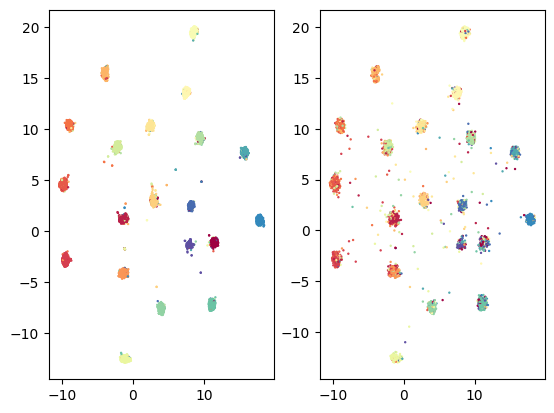

In [16]:
X_reduced_train_lstm, X_reduced_test_lstm = umap_reduce_dim(embedding_matrix_lstm_train, target_matrix_train, embedding_matrix_lstm)
plot_scatter(X_reduced_train_lstm, target_matrix_train, X_reduced_test_lstm, target_matrix, 'lstm')

Algorithm: pre-train model
Data train after embedding
Data test after embedding


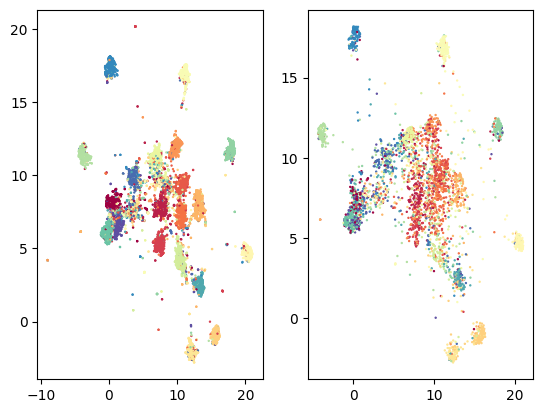

In [17]:
X_reduced_train_glove, X_reduced_test_glove = umap_reduce_dim(text_embedding_train, y_train, text_embedding_test)
plot_scatter(X_reduced_train_glove, y_label_train, X_reduced_test_glove, y_label_test, 'pre-train model')

Algorithm: bag of word
Data train after embedding
Data test after embedding


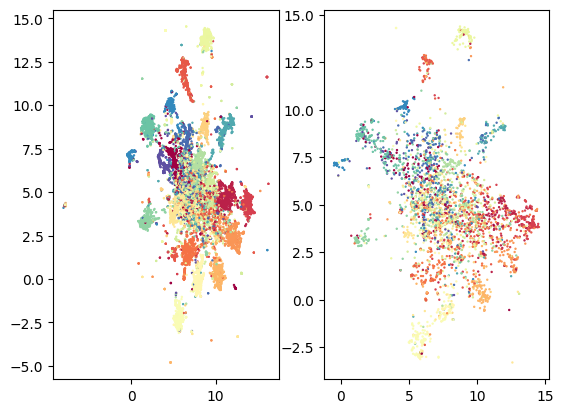

In [18]:
plot_scatter(X_reduced_train_BOW, y_train, X_reduced_test_BOW, y_test, 'bag of word')

Algorithm: tf-idf
Data train after embedding
Data test after embedding


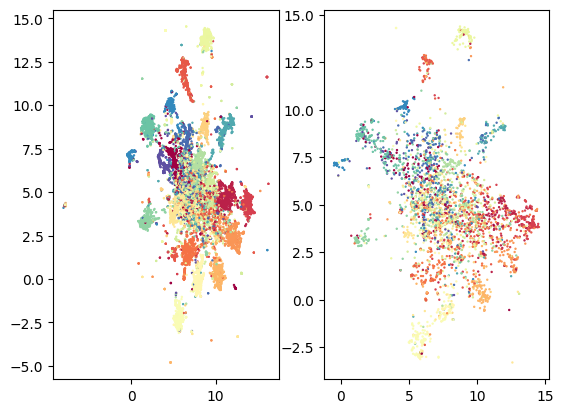

In [19]:
plot_scatter(X_reduced_train_tfidf, y_train, X_reduced_test_tfidf, y_test, 'tf-idf')

In [20]:
from sklearn.metrics import silhouette_score
score_BOW = silhouette_score(X_reduced_test_BOW, y_test)
print("Silhouette score of bag of word is ", score_BOW)

Silhouette score of bag of word is  -0.1569874


In [21]:
score_tdidf = silhouette_score(X_reduced_test_tfidf, y_test)
print("Silhouette score of tf-idf is ", score_tdidf)

Silhouette score of tf-idf is  -0.1569874


In [22]:
score_glove = silhouette_score(X_reduced_test_glove, y_test)
print("Silhouette score of pre-train model glove is ", score_glove)

Silhouette score of pre-train model glove is  -0.07552424


In [23]:
score_lstm = silhouette_score(X_reduced_test_lstm, y_test)
print("Silhouette score of tf-idf is ", score_lstm)

Silhouette score of tf-idf is  -0.050007764


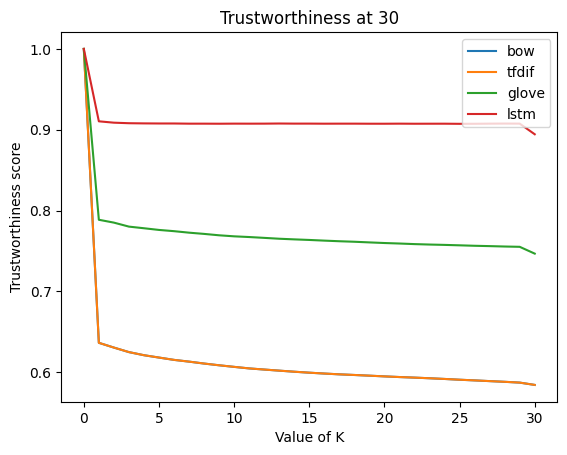

In [31]:
K = 30
filterwarnings('ignore')

trustworthiness_bow = validation.trustworthiness_vector(source=X_train_BOW.toarray()
                                  ,embedding=X_reduced_train_BOW
                                  ,max_k=K)
trustworthiness_tfidf = validation.trustworthiness_vector(source=X_train_BOW.toarray()
                                  ,embedding=X_reduced_train_tfidf
                                  ,max_k=K)
trustworthiness_glove = validation.trustworthiness_vector(source=text_embedding_train
                                  ,embedding=X_reduced_train_glove
                                  ,max_k=K)

trustworthiness_lstm = validation.trustworthiness_vector(source=np.array(embedding_matrix_lstm_train)
                                  ,embedding=X_reduced_train_lstm
                                  ,max_k=K)

filterwarnings('default')


plt.plot(trustworthiness_bow)
plt.plot(trustworthiness_tfidf)
plt.plot(trustworthiness_glove)
plt.plot(trustworthiness_lstm)
plt.ylabel("Trustworthiness score")
plt.xlabel("Value of K")
plt.title(f"Trustworthiness at {K}")
plt.legend(["bow", "tfdif", "glove", "lstm"], loc="upper right")